In [39]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
import string
from sklearn.model_selection import KFold

In [40]:
df = pd.read_csv('dataset/tweetlabels1000_labeled.xlsx - Sheet2.csv')
print(df.shape)
df

(1003, 4)


,No,Label,Username,Tweet
0,0,none,chyrisalys,wifi watcha pasti indihome
1,1,indirect complaint,woiidal,indihome ada masalah apasih??!!
2,2,remark,ranieaw,sore sore hujan rebahan bareng bocil nonton nu...
3,3,negative remark,daeguv_,"indihome plis untuk tanggal 10,13 jangan kesur..."
4,4,indirect complaint,fiorincha,INDIHOME NGAPASIIII
...,...,...,...,...
998,998,campaign,sangwarior,Bisa sharing bareng sobat indihome gini kan as...
999,999,campaign,sangwarior,Sekarang nyantai dulu bentar sambil scroll sos...
1000,1000,negative remark,untextend,@JefriHandri Sini indihome down dr semalem jam...
1001,1001,campaign,sangwarior,Ini barusan slesei sob... Lumayan buat nyari k...


In [41]:
# drop rows with label = campaign, own tweet, & incomplete
df = df.loc[~df['Label'].isin(['campaign','own tweet','incomplete'])].copy()
df

,No,Label,Username,Tweet
0,0,none,chyrisalys,wifi watcha pasti indihome
1,1,indirect complaint,woiidal,indihome ada masalah apasih??!!
2,2,remark,ranieaw,sore sore hujan rebahan bareng bocil nonton nu...
3,3,negative remark,daeguv_,"indihome plis untuk tanggal 10,13 jangan kesur..."
4,4,indirect complaint,fiorincha,INDIHOME NGAPASIIII
...,...,...,...,...
994,994,inquiry,pecintamochi,"@IndiHomeCare Min, kalo jatuh tempo pembayaran..."
995,995,inquiry,tetehaisyah51,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl..."
997,997,direct complaint,untextend,@IndiHomeCare @fauzindrianto Dari semalem down...
1000,1000,negative remark,untextend,@JefriHandri Sini indihome down dr semalem jam...


In [42]:
# Label Encoding & drop columns
df['label'] = df['Label'].map({'indirect complaint': 0, 'remark': 1, 'negative remark': 2, 'direct compliment' : 3 , 'direct complaint' : 4, 'none' : 5, 'inquiry' : 6})
df.drop(['No', 'Label', 'Username'], axis=1, inplace=True)
df

,Tweet,label
0,wifi watcha pasti indihome,5
1,indihome ada masalah apasih??!!,0
2,sore sore hujan rebahan bareng bocil nonton nu...,1
3,"indihome plis untuk tanggal 10,13 jangan kesur...",2
4,INDIHOME NGAPASIIII,0
...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",6
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",6
997,@IndiHomeCare @fauzindrianto Dari semalem down...,4
1000,@JefriHandri Sini indihome down dr semalem jam...,2


In [43]:
df.groupby( by='label').count()

,Tweet
label,
0,68
1,153
2,128
3,64
4,110
5,123
6,76


In [44]:
# to lowercase
df['tweet_lower'] = df['Tweet'].str.lower()
df

,Tweet,label,tweet_lower
0,wifi watcha pasti indihome,5,wifi watcha pasti indihome
1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!
2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...
3,"indihome plis untuk tanggal 10,13 jangan kesur...",2,"indihome plis untuk tanggal 10,13 jangan kesur..."
4,INDIHOME NGAPASIIII,0,indihome ngapasiiii
...,...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",6,"@indihomecare min, kalo jatuh tempo pembayaran..."
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",6,"@indihomecare min, 1 indihome tv bisa gak berl..."
997,@IndiHomeCare @fauzindrianto Dari semalem down...,4,@indihomecare @fauzindrianto dari semalem down...
1000,@JefriHandri Sini indihome down dr semalem jam...,2,@jefrihandri sini indihome down dr semalem jam...


In [45]:
def text_cleansing(text):
    
       
    # remove non ASCII (emoticon, chinese word, etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    
    # remove digits (using regex) -> subtitute
    text = re.sub('\d+', '', text)
    
    # remove punctuation, reference: https://stackoverflow.com/a/34294398
    #text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove punctuation, except mention tag @
    text = re.sub(r'[^\w\s@]', '', text)
    
    # remove whitespace in the beginning and end of sentence
    text = text.strip()
    
    # remove extra whitespace in the middle of sentence (using regex)
    text = re.sub('\s+', ' ', text)
    
    # remove url in tweet (using regex)
    text = re.sub(r"\bhttp\w+", "", text)
    
    return text

In [46]:
# text_cleansing()
df['tweet_clean'] = df['tweet_lower'].apply(lambda x: text_cleansing(x))
df

,Tweet,label,tweet_lower,tweet_clean
0,wifi watcha pasti indihome,5,wifi watcha pasti indihome,wifi watcha pasti indihome
1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih
2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...
3,"indihome plis untuk tanggal 10,13 jangan kesur...",2,"indihome plis untuk tanggal 10,13 jangan kesur...",indihome plis untuk tanggal jangan kesurupan
4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii
...,...,...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",6,"@indihomecare min, kalo jatuh tempo pembayaran...",@indihomecare min kalo jatuh tempo pembayaran ...
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",6,"@indihomecare min, 1 indihome tv bisa gak berl...",@indihomecare min indihome tv bisa gak berlang...
997,@IndiHomeCare @fauzindrianto Dari semalem down...,4,@indihomecare @fauzindrianto dari semalem down...,@indihomecare @fauzindrianto dari semalem down...
1000,@JefriHandri Sini indihome down dr semalem jam...,2,@jefrihandri sini indihome down dr semalem jam...,@jefrihandri sini indihome down dr semalem jam...


In [47]:
# normalization indonesian words
normalized_word = pd.read_csv('dataset/new_kamusalay.csv', header=None)
data_dict = dict(zip(normalized_word[0], normalized_word[1]))
len(data_dict)

15166

In [48]:
def normalize_text(text):
    return ' '.join(data_dict.get(word, word) for word in text.split())

In [49]:
df['tweet_normalized'] = df['tweet_clean'].apply(lambda x: normalize_text(x))
df

,Tweet,label,tweet_lower,tweet_clean,tweet_normalized
0,wifi watcha pasti indihome,5,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome
1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih,indihome ada masalah apa sih
2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocah cilik men...
3,"indihome plis untuk tanggal 10,13 jangan kesur...",2,"indihome plis untuk tanggal 10,13 jangan kesur...",indihome plis untuk tanggal jangan kesurupan,indihome tolong untuk tanggal jangan kesurupan
4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii
...,...,...,...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",6,"@indihomecare min, kalo jatuh tempo pembayaran...",@indihomecare min kalo jatuh tempo pembayaran ...,@indihomecare min kalau jatuh tempo pembayaran...
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",6,"@indihomecare min, 1 indihome tv bisa gak berl...",@indihomecare min indihome tv bisa gak berlang...,@indihomecare min indihome televisi bisa tidak...
997,@IndiHomeCare @fauzindrianto Dari semalem down...,4,@indihomecare @fauzindrianto dari semalem down...,@indihomecare @fauzindrianto dari semalem down...,@indihomecare @fauzindrianto dari semalam down...
1000,@JefriHandri Sini indihome down dr semalem jam...,2,@jefrihandri sini indihome down dr semalem jam...,@jefrihandri sini indihome down dr semalem jam...,@jefrihandri sini indihome down dari semalam j...


In [50]:
# stemming 'kata berimbuhan'
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [51]:
df['tweet_stemmed'] = df['tweet_normalized'].apply(lambda x: stemmer.stem(x))
df

,Tweet,label,tweet_lower,tweet_clean,tweet_normalized,tweet_stemmed
0,wifi watcha pasti indihome,5,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome
1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih,indihome ada masalah apa sih,indihome ada masalah apa sih
2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocah cilik men...,sore sore hujan rebah bareng bocah cilik tonto...
3,"indihome plis untuk tanggal 10,13 jangan kesur...",2,"indihome plis untuk tanggal 10,13 jangan kesur...",indihome plis untuk tanggal jangan kesurupan,indihome tolong untuk tanggal jangan kesurupan,indihome tolong untuk tanggal jangan surup
4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii
...,...,...,...,...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",6,"@indihomecare min, kalo jatuh tempo pembayaran...",@indihomecare min kalo jatuh tempo pembayaran ...,@indihomecare min kalau jatuh tempo pembayaran...,indihomecare min kalau jatuh tempo bayar indih...
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",6,"@indihomecare min, 1 indihome tv bisa gak berl...",@indihomecare min indihome tv bisa gak berlang...,@indihomecare min indihome televisi bisa tidak...,indihomecare min indihome televisi bisa tidak ...
997,@IndiHomeCare @fauzindrianto Dari semalem down...,4,@indihomecare @fauzindrianto dari semalem down...,@indihomecare @fauzindrianto dari semalem down...,@indihomecare @fauzindrianto dari semalam down...,indihomecare fauzindrianto dari malam down tid...
1000,@JefriHandri Sini indihome down dr semalem jam...,2,@jefrihandri sini indihome down dr semalem jam...,@jefrihandri sini indihome down dr semalem jam...,@jefrihandri sini indihome down dari semalam j...,jefrihandri sini indihome down dari malam jam ...


In [52]:
# Define a function to compute the max length of sequence
def max_length(sequences):
    '''
    input:
        sequences: a 2D list of integer sequences
    output:
        max_length: the max length of the sequences
    '''
    max_length = 0
    for i, seq in enumerate(sequences):
        length = len(seq)
        if max_length < length:
            max_length = length
    return max_length

In [53]:
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm

def define_model(input_dim = None, output_dim=300, max_length = None ):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=input_dim, 
                                  mask_zero= True,
                                  output_dim=output_dim, 
                                  input_length=max_length, 
                                  input_shape=(max_length, )),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=False)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=7, activation='sigmoid')
    ])
    
    model.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [54]:
class myCallback(tf.keras.callbacks.Callback):
    # Overide the method on_epoch_end() for our benefit
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training=True


callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=10, verbose=2, 
                                             mode='auto', restore_best_weights=True)

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.utils.np_utils import to_categorical

# Parameter Initialization
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

columns = ['acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6', 'acc7', 'acc8', 'acc9', 'acc10', 'AVG']
record = pd.DataFrame(columns = columns)

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(n_splits=10, shuffle=False, random_state=None)

# Separate the tweet and label
tweets, labels = list(df.tweet_stemmed), list(df.label)

exp=0

# kfold.split() will return set indices for each split
acc_list = []
for train, test in kfold.split(tweets):
    
    exp+=1
    print('Training {}: '.format(exp))
    
    train_x, test_x = [], []
    train_y, test_y = [], []

    for i in train:
        train_x.append(tweets[i])
        train_y.append(labels[i])

    for i in test:
        test_x.append(tweets[i])
        test_y.append(labels[i])

    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # one-hot
    onehot_train_y = to_categorical(train_y)
    onehot_test_y = to_categorical(test_y)

    # encode data using Cleaning and Tokenization
    tokenizer = Tokenizer(oov_token=oov_tok)
    tokenizer.fit_on_texts(train_x)

    # Turn the text into sequence
    training_sequences = tokenizer.texts_to_sequences(train_x)
    test_sequences = tokenizer.texts_to_sequences(test_x)

    max_len = max_length(training_sequences)

    # Pad the sequence to have the same size
    Xtrain = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
    Xtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    word_index = tokenizer.word_index
    vocab_size = len(word_index)+1

    # Define the input shape
    model = define_model(input_dim=vocab_size, max_length=max_len)

    # Train the model
    model.fit(Xtrain, onehot_train_y, batch_size=32, epochs=30, verbose=1, 
              callbacks=[callbacks], validation_data=(Xtest, onehot_test_y))

    # evaluate the model
    loss, acc = model.evaluate(Xtest, onehot_test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))

    acc_list.append(acc*100)

mean_acc = np.array(acc_list).mean()
entries = acc_list + [mean_acc]

temp = pd.DataFrame([entries], columns=columns)
record = record.append(temp, ignore_index=True)
print()
print(record)
print()

Training 1: 
Epoch 1/30
21/21 [==============================] - 22s 413ms/step - loss: 1.9012 - accuracy: 0.2558 - val_loss: 2.0164 - val_accuracy: 0.0685
Epoch 2/30
21/21 [==============================] - 3s 161ms/step - loss: 1.7113 - accuracy: 0.3282 - val_loss: 1.9348 - val_accuracy: 0.2603
Epoch 3/30
21/21 [==============================] - 3s 164ms/step - loss: 1.2766 - accuracy: 0.5778 - val_loss: 2.0649 - val_accuracy: 0.3288
Epoch 4/30
21/21 [==============================] - 4s 183ms/step - loss: 0.7592 - accuracy: 0.7535 - val_loss: 2.0824 - val_accuracy: 0.3425
Epoch 5/30
21/21 [==============================] - 4s 174ms/step - loss: 0.4177 - accuracy: 0.8706 - val_loss: 2.3121 - val_accuracy: 0.2466
Epoch 6/30
21/21 [==============================] - 4s 169ms/step - loss: 0.2182 - accuracy: 0.9368 - val_loss: 2.5871 - val_accuracy: 0.2603
Epoch 7/30
21/21 [==============================] - 3s 160ms/step - loss: 0.1158 - accuracy: 0.9738 - val_loss: 3.1034 - val_accuracy:

Epoch 9/30
21/21 [==============================] - 3s 139ms/step - loss: 0.0953 - accuracy: 0.9708 - val_loss: 2.6297 - val_accuracy: 0.3889
Epoch 10/30
21/21 [==============================] - 3s 134ms/step - loss: 0.0688 - accuracy: 0.9785 - val_loss: 2.7559 - val_accuracy: 0.3750
Epoch 11/30
21/21 [==============================] - 3s 135ms/step - loss: 0.0523 - accuracy: 0.9877 - val_loss: 2.8804 - val_accuracy: 0.3889
Epoch 12/30
21/21 [==============================] - 3s 136ms/step - loss: 0.0412 - accuracy: 0.9862 - val_loss: 3.0637 - val_accuracy: 0.4028
Epoch 13/30
21/21 [==============================] - 3s 138ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 3.2368 - val_accuracy: 0.3889
Epoch 14/30
21/21 [==============================] - 3s 136ms/step - loss: 0.0307 - accuracy: 0.9908 - val_loss: 3.3327 - val_accuracy: 0.3889
Epoch 00014: early stopping
Test Accuracy: 41.66666567325592
Training 5: 
Epoch 1/30
21/21 [==============================] - 18s 321ms/step - 

21/21 [==============================] - 3s 156ms/step - loss: 1.7073 - accuracy: 0.3292 - val_loss: 1.6021 - val_accuracy: 0.3750
Epoch 3/30
21/21 [==============================] - 4s 169ms/step - loss: 1.2712 - accuracy: 0.5446 - val_loss: 1.4161 - val_accuracy: 0.4722
Epoch 4/30
21/21 [==============================] - 3s 145ms/step - loss: 0.8103 - accuracy: 0.7354 - val_loss: 1.4995 - val_accuracy: 0.4722
Epoch 5/30
21/21 [==============================] - 3s 140ms/step - loss: 0.4590 - accuracy: 0.8646 - val_loss: 1.9689 - val_accuracy: 0.4167
Epoch 6/30
21/21 [==============================] - 3s 155ms/step - loss: 0.2417 - accuracy: 0.9308 - val_loss: 1.7187 - val_accuracy: 0.5417
Epoch 7/30
21/21 [==============================] - 3s 149ms/step - loss: 0.1533 - accuracy: 0.9508 - val_loss: 2.3040 - val_accuracy: 0.4444
Epoch 8/30
21/21 [==============================] - 3s 151ms/step - loss: 0.1150 - accuracy: 0.9646 - val_loss: 2.0346 - val_accuracy: 0.5139
Epoch 9/30
21/21 

C:\Users\970068\AppData\Local\Temp\ipykernel_10804\3147406012.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  record = record.append(temp, ignore_index=True)


In [56]:
record

,acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8,acc9,acc10,AVG
0,34.246576,41.095892,43.055555,41.666666,47.222221,51.38889,50.0,54.166669,40.277779,43.055555,44.61758


In [57]:
# define the preprocessing pipeline
def text_preprocessing(text):
    # case folding
    text = text.lower()
    
    # text cleansing
    text = text_cleansing(text)
    
    # text normalization
    text = normalize_text(text)
    
    # stemming
    text = stemmer.stem(text)
    
    return text

In [58]:
# predicting a text
from keras.utils.np_utils import to_categorical

def text_predict(text):
    
    # preprocess
    text_cleaned = text_preprocessing(text)
    text_sequence = tokenizer.texts_to_sequences([text_cleaned])

    max_len= max_length(training_sequences)

    seq_padded = pad_sequences(text_sequence, maxlen=max_len, padding=padding_type, truncating=trunc_type)

    # prediction
    pred_proba = model.predict(seq_padded)

    result = np.argmax(pred_proba)

    return result

In [59]:
# prediction test
text_predict('Indihome sampah')

2

In [60]:
# predicting data set

df['tweet_predict'] = df['tweet_stemmed'].apply(lambda x: text_predict(x))
df

,Tweet,label,tweet_lower,tweet_clean,tweet_normalized,tweet_stemmed,tweet_predict
0,wifi watcha pasti indihome,5,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,wifi watcha pasti indihome,5
1,indihome ada masalah apasih??!!,0,indihome ada masalah apasih??!!,indihome ada masalah apasih,indihome ada masalah apa sih,indihome ada masalah apa sih,2
2,sore sore hujan rebahan bareng bocil nonton nu...,1,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocil nonton nu...,sore sore hujan rebahan bareng bocah cilik men...,sore sore hujan rebah bareng bocah cilik tonto...,1
3,"indihome plis untuk tanggal 10,13 jangan kesur...",2,"indihome plis untuk tanggal 10,13 jangan kesur...",indihome plis untuk tanggal jangan kesurupan,indihome tolong untuk tanggal jangan kesurupan,indihome tolong untuk tanggal jangan surup,2
4,INDIHOME NGAPASIIII,0,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,indihome ngapasiiii,2
...,...,...,...,...,...,...,...
994,"@IndiHomeCare Min, kalo jatuh tempo pembayaran...",6,"@indihomecare min, kalo jatuh tempo pembayaran...",@indihomecare min kalo jatuh tempo pembayaran ...,@indihomecare min kalau jatuh tempo pembayaran...,indihomecare min kalau jatuh tempo bayar indih...,6
995,"@IndiHomeCare Min, 1 IndiHome TV bisa gak berl...",6,"@indihomecare min, 1 indihome tv bisa gak berl...",@indihomecare min indihome tv bisa gak berlang...,@indihomecare min indihome televisi bisa tidak...,indihomecare min indihome televisi bisa tidak ...,6
997,@IndiHomeCare @fauzindrianto Dari semalem down...,4,@indihomecare @fauzindrianto dari semalem down...,@indihomecare @fauzindrianto dari semalem down...,@indihomecare @fauzindrianto dari semalam down...,indihomecare fauzindrianto dari malam down tid...,6
1000,@JefriHandri Sini indihome down dr semalem jam...,2,@jefrihandri sini indihome down dr semalem jam...,@jefrihandri sini indihome down dr semalem jam...,@jefrihandri sini indihome down dari semalam j...,jefrihandri sini indihome down dari malam jam ...,4


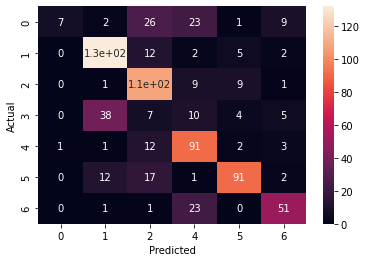

In [62]:
# confusion matrix  
# source: https://datatofish.com/confusion-matrix-python/

confusion_matrix = pd.crosstab(df['label'], df['tweet_predict'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

# labels:
        #0: indirect complaint
        #1: remark
        #2: negative remark
        #3: direct compliment
        #4: direct complaint
        #5: none
        #6: inquiry